# Are Individual Health Insurance Markets Competitive? Plan Options Faced by Individuals

### By Laura Gascue
### July 2020

Since 2014, with the Affordable Care Act (ACA), individuals without access to health care insurance through employment, can purchase one in the Health Insurance Individual Marketplace. The system was created to ensure a set of minimum coverage standards at affordable cost, aiming to widely expand access to health insurance. The mechanism to achieve this relies on a set of regulations placed on insurers and on market competition. The question we explore here is, are these markets competitive?

We could go over the long academic discussion on how to measure competition levels, or discuss for example the Herfindahl–Hirschman Index (HHI). We are not doing this here. At the end of the day a consumer want to know if they have options. From the firms point of view, the question becomes, is there space for one more product?

We limit the analysis to the observed final result: how many options an individual faces when choosing health insurance in the Insurance Exchange Marketplace, where plans offered have guarantees in terms of coverage and premiums. First we look at the distribution of number of plans offered, and explore correlations with geographic area characteristics. Second, we consider relevant factors that could be used to explain this measure. We look at state and governors’ political affiliation, population size, unemployment level, number of health professionals or health facilities available in the area, population age and population income, among other variables. We also consider the number of issuers in each area. Finally we try to predict the number of health insurance plans offered in the marketplace for individuals using geographic area characteristics.

The analysis is restricted to the health insurance plans being offered in the US in 2018 through the federally facilitated market place. There are 39 states under the federal program. An individual will have access to the plans offered in the area they live (offered in their county). We compute the number of plans being offered in each FIPS county code area on those states and use it as a measure of the level of competition in that market. 


## Federally Facilitated Marketplace Plans in 2018 by FIPS

### The Data

The Centers for Medicare & Medicaid Services uploads health insurance plan information on the federally facilitated marketplace through the healthcare.gov website. The latest complete data available corresponds to the plans available in 2018 (the data can be downloaded from 2018 QHP landscape data). We use this file to create count of plans and insurance companies operating in each county.

We use the Area Health Resource File (AHRF) downloaded from the Health Resource and Services Administration website to associate market characteristics to the plans data. The file combines health and other socioeconomic data sources on specific geographic areas in the US. I downloaded the set of files with measures at the County level.

For the analysis described in this note we use the file plans_data.json with summary information on plans offered under the ACA individual isurance markets on each county. The file includes for each county (CBSA or FIPS) the following measures:
* count_plans - count of different plans offered,
* count_issuers - number of different insurance companies offereing plans,
* Pop2017 - County population in 2017 (from AHRF)
* MedIncome2017 - County median income in 2017 (from AHRF)
* IndMarketEnroll2017 - Number of individuals enrolled in a health insurance plan though the individual marketplace in 2017 (from AHRF)
* Unemployment - County unemployment rate (from AHRF)
* Num_Hosp2017 - Number of Hospitals in the area
* Pparty - State's governor political affiliation at the begining of 2018

Other variables include:
* fips_st - Fips state code
* fips_county - Fips_county

Data sources:

(1) 2018 QHP landscape data downloaded from https://www.healthcare.gov/health-plan-information-2018/

(2) Area resource health file downloaded from https://data.hrsa.gov/data/download - Area Health Resources Files (AHRF) 2018-2019. US Department of Health and Human Services, Health Resources and Services Administration, Bureau of Health Workforce, Rockville, MD.

(3) File All_States_Governors_Party.csv identifying state's governor politic party affiliation at the beginning of 2018 for all fifty states, manually constructed through web searches.

For additional details on the creation of this dataset check the notebooks "Capstone 1 - Building the analtyic dataset.ipynb" and "AHRF_Dictionary.ipynb".


The analysis is limited to the states running under the federal government platform in 2018, and the set of qualified health plans (QHP) offered. Some states, like California with Covered California, chose to run their own Marketplace. The original file has 39,348 rows and a large number of columns. We only read in a subset of columns, containing plan identification variables, plan type, geographic area where offered (at the FIPS County Code Level), and plan premiums, a total of 16 columns. The database cover 39 states: AK, AL, FL, AR, AZ, DE, GA, IL, MI, HI, MO, IA, IN, MS, KS, KY, LA, ME, MT, PA, ND, NJ, NE, NM, NH, NC, OR, WI, NV, OH, OK, SD, SC, VA, TX, TN, UT, WV, WY.



In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import sklearn components
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble  import BaggingRegressor

In [3]:
# Set paths and file names

projpath='C:\\Users\\l_gas\\Documents\\Development\\SpringBoard_DataScience\\CapstoneProj1'

# Read analytic file with regional population measures and merge with party affiliation data
plans_data = (pd.read_json("./plans_data.json"))

# Create a new column with FIPS code formated as a string with length 5.
plans_data['fips_str'] = [str(x).zfill(5) for k, x in plans_data.fips.items()]
print(plans_data.head())


   fips  count_plans  count_issuers    state  st  fips_st  fips_county  \
0  1001            7              1  Alabama  AL        1            1   
1  1003            7              1  Alabama  AL        1            3   
2  1005            7              1  Alabama  AL        1            5   
3  1007            7              1  Alabama  AL        1            7   
4  1009            7              1  Alabama  AL        1            9   

      CBSA                           CBSA_Name  CBSA_Ind CBSA_Status  \
0  33860.0             Montgomery, AL Metro SA         1     Central   
1  19300.0  Daphne-Fairhope-Foley, AL Metro SA         1     Central   
2  21640.0             Eufaula, AL-GA Micro SA         2     Central   
3  13820.0      Birmingham-Hoover, AL Metro SA         1    Outlying   
4  13820.0      Birmingham-Hoover, AL Metro SA         1    Outlying   

   Num_Hosp2017  Pop2017  MedIncome2017  IndMarketEnroll2017  Unemployment  \
0             1    55504          58343     

The number of plans offered across all counties participating in the federally mandated markets ranges from 2 to 119, with an average number of 14 plans, and a median of 12 plans. The distribution is concentrated on the left of the curve with an interquartile range of 11. Half of the counties offered a number of plans between 7 and 18. In order to factor the size of each geographic area, and reflect the options faced by all individuals in those areas we use the 2017 enrollment in these markets to evaluate this distribution. Fig 1 shows the distribution of the number of options faced by individuals in this market.

However, many of these plans target different individuals and they may be offered by the same insurance company (issurer) applying market segmentation strategies. Taking this into account, we can look at the number of issuers participating in each area. The options now are highly reduced. The number of issuers range from 1 to 7, with 75% of the areas having one or two participants. Fig 2 shows the distribution of number of issuer optons faced by individuals in this market.

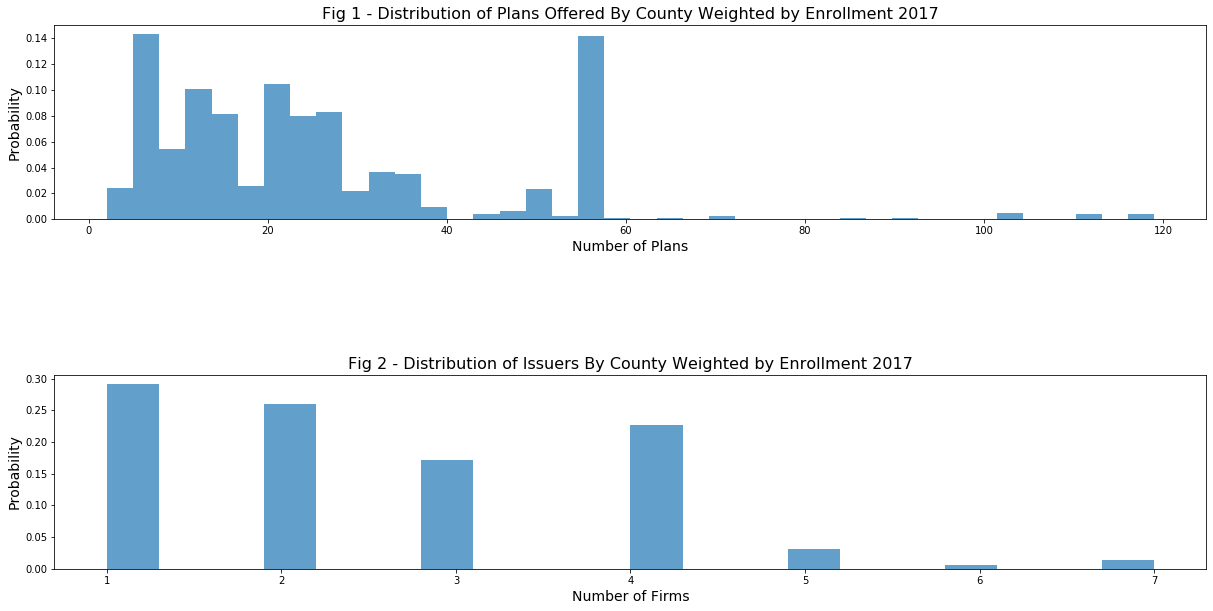

In [4]:
# How many plans/issuers individuals face?
# we use last year's market size to weight number of plans per FIP codes.
# change to seaborn
plt.figure(figsize=(20,10))
wgt = plans_data['IndMarketEnroll2017']/np.sum(plans_data['IndMarketEnroll2017'])

plt.subplot(211)
plt.hist(plans_data['count_plans'],bins=40, weights=wgt, alpha=0.7)
plt.title("Fig 1 - Distribution of Plans Offered By County Weighted by Enrollment 2017", size=16)
plt.xlabel("Number of Plans",size=14)
plt.ylabel("Probability",size=14)

plt.subplot(212)
plt.hist(plans_data['count_issuers'], bins=20, weights=wgt, alpha=0.7)
plt.title("Fig 2 - Distribution of Issuers By County Weighted by Enrollment 2017", size=16)
plt.xlabel("Number of Firms",size=14)
plt.ylabel("Probability",size=14)

plt.subplots_adjust(left=0.1, right=0.9 ,hspace=0.8)
plt.savefig("Data description-figure 1_2.png")

## Dispersion Accross States

The areas analyzied here are limited to states with Individual Market health insurance federally regulated. However, States behave different. The distribution of the number of plans available varies widely across states. Median number of plans offered by state ranges from 4 to 36. Among states offering larger options we see Florida and Wisconsin. In the lower end we see Alaska, Arizona, Mississippi and Iowa. This results suggests that even under federally mandated states, probably state regulations have an effect in these markets. See Fig. 3.

Another aspect that may help identify areas with different options is population size. We group counties into Metropolitan Statistical Areas (area with one or more urban areaof 50,000 or more), Micropolitan Statistical Areas (areas with one urban cluster of 10,000 people but less than 50,000) and Non-Statistical Area, with no urban areas of 10,000 people or more. The distribution under the two lowest population categories shows areas with similar health plan options and similar dispersion, while the areas with higher population present a tendency to have more health plan options and higher variability.

For additional data descripton see Capstone 1 - Data Description.ipynb.

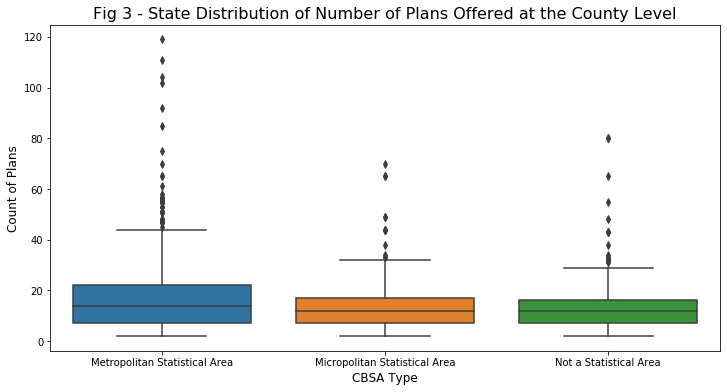

In [5]:
# how many plans offered on each State - Distribution
pop_size = plans_data[["count_plans","CBSA_Ind"]].replace({"CBSA_Ind" : {0: "Not a Statistical Area", 1 : "Metropolitan Statistical Area", 2 : "Micropolitan Statistical Area"}})

plt.figure(figsize=(12,6))
_ = sns.boxplot(x='CBSA_Ind', y='count_plans', data=pop_size) 
# may be sort by state population size or color by it. 
_ = plt.title("Fig 3 - State Distribution of Number of Plans Offered at the County Level", size=16)
_ = plt.ylabel("Count of Plans", size=12)
_ = plt.xlabel("CBSA Type", size=12)
plt.savefig("Data description - Boxplot by county type.png")

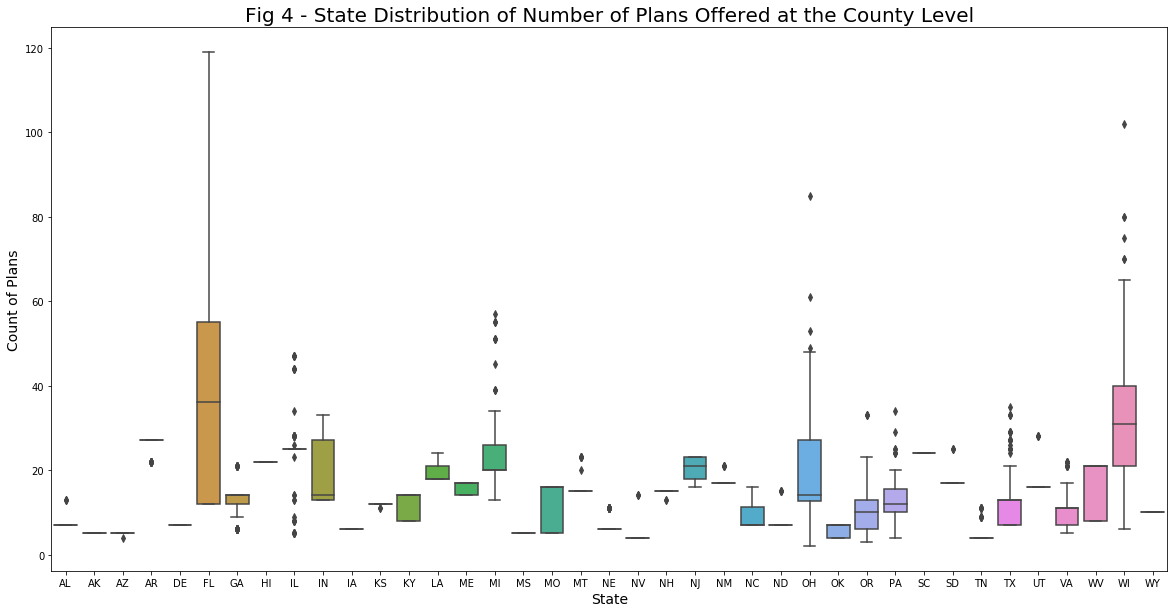

In [6]:
# how many plans offered on each State - Distribution
plt.figure(figsize=(20,10))
_ = sns.boxplot(x='st', y='count_plans', data=plans_data) 
# may be sort by state population size or color by it. 
_ = plt.title("Fig 4 - State Distribution of Number of Plans Offered at the County Level", size=20)
_ = plt.ylabel("Count of Plans", size=14)
_ = plt.xlabel("State", size=14)
plt.savefig("Data description-figure 4.png")

## How Number of Plans Offered Changes Depending on Governor’s Party Affiliation?

We identify the governor's political party at the beginning of 2018 for each of the states with Federally RegulFacilitated Individual Markets under the ACA. There are 9 states under a democratic governor, 29 states under a republican governor, and one state with an independent governor. Note that the number of democratic states opting to regulate their own markets is proportionally larger than the number of republican states choosing this option. Since we have just one state with an independent governor, we leave this state out of the analysis. 

In [7]:
# Look at distribution of Political Party Governors in Federally vs State Facilitated Markets
stparty= projpath + "\\All_States_Governors_Party.csv"
stparty_all = pd.read_csv(stparty)
fed_stparty =stparty_all[stparty_all['Market_Reg']=='Federal']
own_stparty =stparty_all[stparty_all['Market_Reg']!='Federal']

print("Federally Facilitated Markets:", fed_stparty.groupby('Pparty')['State Code'].count())
print("State Run Markets:", own_stparty.groupby('Pparty')['State Code'].count())


Federally Facilitated Markets: Pparty
Democratic      9
Independent     1
Republican     29
Name: State Code, dtype: int64
State Run Markets: Pparty
Democratic    7
Republican    4
Name: State Code, dtype: int64


The large majority of the counties offer health insurance through no more than four companies. States with a Republican governor tend to have fewer issuers with 87% of counties presenting just one or two issuers but a longer right tail. In contrast, counties under a Democratic governor presenting one or two issuers account for 64.5% of all counties. The differences in the distribution of the number of plans is less clear (see Figure 4) but still shows a more concentrated distribution in Democratic counties, but slightly shifted to the right, respect to the distribution in Republican counties. 

In [8]:
# Define labels
party = ['Democratic','Independent','Republican']

# Get percent of FIPS with 1, 2, ... number of issuers
plans_data_dr = plans_data[plans_data['Pparty']!='Independent']
fips_by = pd.DataFrame(plans_data_dr.groupby(['count_issuers','Pparty'])['fips'].agg(['count']).unstack())
fips_by_p = pd.DataFrame()
fips_by_p['Democratic (%)'] = fips_by['count']['Democratic']/fips_by['count']['Democratic'].sum()*100
fips_by_p['Republican (%)'] = fips_by['count']['Republican']/fips_by['count']['Republican'].sum()*100

print(fips_by_p)


               Democratic (%)  Republican (%)
count_issuers                                
1                   46.074380       57.751587
2                   18.388430       29.238441
3                   30.371901        4.125113
4                    4.545455        6.844968
5                    0.619835        1.677244
6                         NaN        0.226655
7                         NaN        0.135993


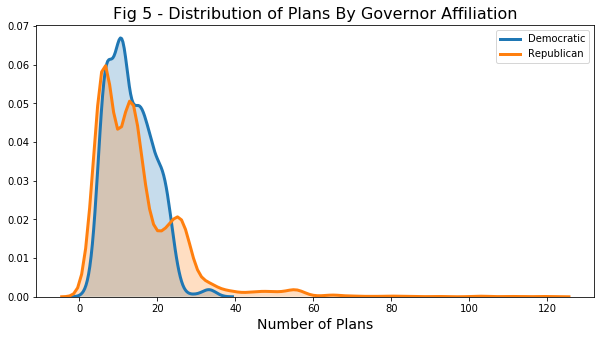

In [9]:
# List all political party state affiliations
party = ['Democratic','Republican']
plt.figure(figsize=(10,5))
for p in party:
    # Subset to the airline
    subset = plans_data_dr[plans_data_dr['Pparty'] == p]
    # Draw the density plot
    sns.distplot(subset['count_plans'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = p)
    
_ = plt.title("Fig 5 - Distribution of Plans By Governor Affiliation", size=16)
_ = plt.xlabel("Number of Plans", size=14)
plt.savefig("Statistical Analysis-figure 5.png")


We are going to test the hypothesis that the expected number of plans in states with a Democratic Governor ($\mu_{D}$) is the same as the expected number of plans in states with a Republican Governor ($\mu_{R}$).

H0: $\mu_{D} = \mu_{R}$

We use a bootstrap approach to test this hypothesis. Under the null hypothesis the expected value of both means is the same, but their variance is not necessary the same. To generate bootstrap replicates we shift both distributions so their means are the same and we sample multiple times from it. We use $\tau = \mu_{D} - \mu_{R}$ to test the hypothesis.

We take 10,000 samples from the shifted distribution of plans, and for each simulation we compute $\hat \tau$ as the difference between both averages. Under the null hypothesis, observing a difference of -1.71 is highly unusual (p-value $\approx$ 0). Given that a state opts to have their individual health insurance market regulated by the Federal Government, States with Republican governors tend to have more plan options for individuals. 


In [10]:

# Get actual values for each group of states
plans_dem = (plans_data_dr.count_plans[plans_data.Pparty=='Democratic'])
plans_rep = (plans_data_dr.count_plans[plans_data.Pparty=='Republican'])
diff_mean = np.mean(plans_dem) - np.mean(plans_rep)
print("Avg Num of Plans - Democratic States", np.mean(plans_dem))
print("Avg Num of Plans - Republican States", np.mean(plans_rep))
print("Difference in Means", diff_mean)

# Shift the distributions
plans_dem_sft = plans_dem-plans_dem.mean()+plans_data_dr['count_plans'].mean()
plans_rep_sft = plans_rep-plans_rep.mean()+plans_data_dr['count_plans'].mean()

# Apply boostrap sampling to the shifted distributions
N_rep = 10000
diff_mean_bs = np.empty(N_rep)
for i in range(N_rep):
    plans_dem_bs = np.random.choice(plans_dem_sft,len(plans_dem_sft))
    plans_rep_bs = np.random.choice(plans_rep_sft,len(plans_rep_sft))
    diff_mean_bs[i] = np.mean(plans_dem_bs) - np.mean(plans_rep_bs)

p_val_meandiff0 = sum(diff_mean_bs<diff_mean)/len(diff_mean_bs)
print("p-value from testing equal means:")
print(p_val_meandiff0)


Avg Num of Plans - Democratic States 13.15702479338843
Avg Num of Plans - Republican States 14.868087035358114
Difference in Means -1.7110622419696835
p-value from testing equal means:
0.0


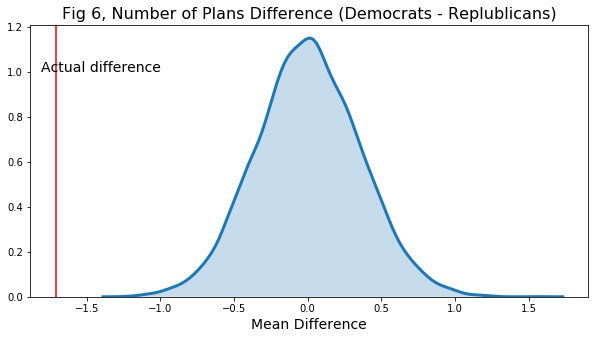

In [11]:
plt.figure(figsize=(10,5))

sns.distplot(diff_mean_bs, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})
_ = plt.axvline(diff_mean, 0,1, color='r')
_ = plt.text(diff_mean-0.1,1,"Actual difference", size=14) 
_ = plt.xlabel("Mean Difference", size=14)
_ = plt.title("Fig 6, Number of Plans Difference (Democrats - Replublicans)", size=16)
plt.savefig("Statistical Analysis-figure 6.png")


There is a significant difference between counties under a Democratic and a Republican governor in the number of health plan options and individual faces when purchasing insurance through federally facilitated individual market exchanges. The number of options is higher for Republican areas though the size of the difference is small (1.7 in a market with on average about 14 different plans). However, the expected number of insurance companies operating in those counties is lower in Republican areas. 

## Can We Predict The Number of Plan Options in the Market

The simplest approach to model number of plans faced by consumers in the individual health insurance market is the linear model. The approach we chose here is to model plan count starting with a simple approach and then introduce alternative, more complex modeling like bagging. The goal is to be able to predict the number of plans, and evaluate the explanatory power of market characteristic variables. We compare the results linear model results with a tree regression approach and the random forest. We pay special attention to the number of players in the market.


### Fitting a Linear Model

We run the traditional linear model. However, we explore two more robust versions of linear regression, the Ridge and Laso regression, which penalize the number of explanatory variables used. We split the model into a training and test sets (70%-30%). We use a training set to evaluate the three alternatives using cross validation with 3-folds. Then we use the test set to evaluate the selected model fit.

Tl evaluate the fit we can use the R2, mean squared error (MSE), and mean absolute error (MAE). The R2 shows the proportion of the dependent variable variance explained by the model. When comparing two models, a higher R2 implies the model has better predictive power. The MSE and MAE use individual points prediction error, and are measures of the model's lack of predicted power. A lower mean squared or absolute error implies the model has better predictive power. The MSE places a higher penalty to larger errors than the MAE.


In [12]:
## SET THE MATRICES TO FIT A MODEL FOR NUMBER OF PLANS AVAILABLE AT THE COUNTY LEVEL
def label_ind (row):
   if row['CBSA_Ind'] == 0 :
      return 'Not a CBSA'
   if row['CBSA_Ind'] == 1 :
      return 'MetroCBSA'
   if row['CBSA_Ind'] == 2 :
      return 'MicroCBSA'

cbsa_type = plans_data.apply (lambda row: label_ind(row), axis=1)

XP_raw = pd.DataFrame(data={'cbsa_type': cbsa_type, 'pop': plans_data.Pop2017, 'medinc': plans_data.MedIncome2017, 'enrol': plans_data.IndMarketEnroll2017,
                            'unemp': plans_data.Unemployment, 'state': plans_data.state, 'Pparty': plans_data.Pparty, 'hosp': plans_data.Num_Hosp2017,'Issuer': plans_data.count_issuers})
YP = plans_data[['count_plans']]

# Generate dumies from categorical variables and drop one level to avoid colinearity. 
XP = pd.get_dummies(XP_raw)
XP = XP.drop(['state_Texas','cbsa_type_MetroCBSA','Pparty_Republican'],axis=1)


In [13]:
# Apply Cross Validation to the Linear Regression Fit - Explore aternative models penalizing for number of variables included
# in the model: Ridge and Lasso regression 

XP_train, XP_test, YP_train, YP_test = train_test_split(XP.to_numpy(), YP.to_numpy(), test_size = 0.3, random_state = 42)

reg=LinearRegression()
cv_scr = cross_validate(reg, XP_train, YP_train, cv=3, scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error'])
rdgreg=Ridge()
cv_scr_rdg = cross_validate(rdgreg, XP_train, YP_train, cv=3, scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error'])
lssreg=Lasso()
cv_scr_lss = cross_validate(lssreg, XP_train, YP_train, cv=3, scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error'])


In [14]:
print("LINEAR REGRESSION")
print("Mean Squared Error: %0.2f  (+/- %0.2f)" % (cv_scr['test_neg_mean_squared_error'].mean()*-1,2*cv_scr['test_neg_mean_squared_error'].std()))
print("Mean Absolute Error: %0.2f  (+/- %0.2f)" % (cv_scr['test_neg_mean_absolute_error'].mean()*-1,2*cv_scr['test_neg_mean_absolute_error'].std()))
print("R2: %0.2f  (+/- %0.2f)" % (cv_scr['test_r2'].mean(),2*cv_scr['test_r2'].std()))

print("RIDGE REGRESSION")
print("Mean Squared Error: %0.2f  (+/- %0.2f)" % (cv_scr_rdg['test_neg_mean_squared_error'].mean()*-1,2*cv_scr_rdg['test_neg_mean_squared_error'].std()))
print("Mean Absolute Error: %0.2f  (+/- %0.2f)" % (cv_scr_rdg['test_neg_mean_absolute_error'].mean()*-1,2*cv_scr_rdg['test_neg_mean_absolute_error'].std()))
print("R2: %0.2f  (+/- %0.2f)" % (cv_scr_rdg['test_r2'].mean(),2*cv_scr_rdg['test_r2'].std()))

print("LASSO REGRESSION")
print("Mean Squared Error: %0.2f  (+/- %0.2f)" % (cv_scr_lss['test_neg_mean_squared_error'].mean()*-1,2*cv_scr_lss['test_neg_mean_squared_error'].std()))
print("Mean Absolute Error: %0.2f  (+/- %0.2f)" % (cv_scr_lss['test_neg_mean_absolute_error'].mean()*-1,2*cv_scr_lss['test_neg_mean_absolute_error'].std()))
print("R2: %0.2f  (+/- %0.2f)" % (cv_scr_lss['test_r2'].mean(),2*cv_scr_lss['test_r2'].std()))


LINEAR REGRESSION
Mean Squared Error: 22.84  (+/- 9.86)
Mean Absolute Error: 2.68  (+/- 0.12)
R2: 0.77  (+/- 0.02)
RIDGE REGRESSION
Mean Squared Error: 23.02  (+/- 11.14)
Mean Absolute Error: 2.68  (+/- 0.14)
R2: 0.77  (+/- 0.02)
LASSO REGRESSION
Mean Squared Error: 55.75  (+/- 25.28)
Mean Absolute Error: 5.06  (+/- 0.37)
R2: 0.44  (+/- 0.03)


When comparing the three linear regression options tested, the Lasso regression clearly doesn't do a good job and the other two have very similar scores (within the 95% confidence interval). The average MSE obtained with the linear fit is slightly better than the Ridge regression (though not statistically different), and since the linear regression is widely used, the first inclination is to chose the linear regression model.

An additional test can be run for the selected model using the test set we extracted before. Besides the R2, MSE and MAE, we can also construct an accuracy measure based on an absolute desired maximum error. In this case we are trying to predict the number of plans offered, with an average level of 14.5. We can set the maximum error at 3 plans, about 20% of the mean. 


In [15]:
reg.fit(XP_train,YP_train)
print("LINEAR REGRESSION EVALUATION ON TEST SET")
print("Mean Squared Error %0.2f" % mean_squared_error(YP_test, reg.predict(XP_test)))
print("Mean Absolute Error %0.2f" % mean_absolute_error(YP_test, reg.predict(XP_test)))
print("R2: %0.2f" % r2_score(YP_test, reg.predict(XP_test)))
large_error = abs(YP_test-reg.predict(XP_test))>3
perc_lrgerror = large_error.sum()/len(large_error)*100
print("Counties with an absolute error larger than 3: %0.2f" % perc_lrgerror,"%")

LINEAR REGRESSION EVALUATION ON TEST SET
Mean Squared Error 31.71
Mean Absolute Error 3.05
R2: 0.77
Counties with an absolute error larger than 3: 31.25 %


In [16]:
print("FINAL FIT USING FULL DATA SET")
reg.fit(XP,YP)
print("Mean Squared Error %0.2f" % mean_squared_error(YP, reg.predict(XP)))
print("Mean Absolute Error %0.2f" % mean_absolute_error(YP, reg.predict(XP)))
print("R2: %0.2f" % r2_score(YP, reg.predict(XP)))
large_error = abs(YP_test-reg.predict(XP_test))>3
perc_lrgerror = large_error.sum()/len(large_error)*100
print("Counties with an absolute error larger than 3: %0.2f" % perc_lrgerror,"%")

FINAL FIT USING FULL DATA SET
Mean Squared Error 23.61
Mean Absolute Error 2.74
R2: 0.79
Counties with an absolute error larger than 3: 29.66 %


As expected, the fit on the test set is slightly worse than when testing using the training set, even after cross validation. Can this model be improved? We turn to ensemble methods.

### The Random Forest

An alternative to the linear regression is to fit a classification tree regression. This approach allows for additional flexibility, taking into account non-linear relationships with the dependent variable. The algorithm takes one explanatory variable (or feature) at a time and uses it to split the target variable in two groups at each node, evaluating the split using the desired score. In this case we use the MSE, penalizing larger errors more than the MAE.

The decision tree regression tends to over fit the sample and get poor results when applied to a data set different from the training one. This method can be strengthen by randomizing the features and samples, and fitting the model multiple times. This is called the Random Forest Regression. By fitting the tree on a subset of the training set and testing on the rest we avoid overfitting. It prepares the tree to fit on unknown values. Once multiple trees are estimated this method uses the average predicted values across all trees.

We again split the data into a training and test set, use the training set to fit the forest, and evaluate the fit on the test set. We use 100 samples (trees), with the randomize option but we include all features in the trees. Using a random forest model gets a better fit than the linear regression approach.


In [17]:
# Fit Random Forest Regression

# Train the Model
XP_train, XP_test, YP_train, YP_test = train_test_split(XP.to_numpy(), YP.to_numpy(), test_size = 0.3, random_state = 11)

rf_mod = RandomForestRegressor(n_estimators = 100, max_features='auto', random_state = 42)
rf_mod.fit(XP_train,YP_train.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [18]:
# Use the Model to Predict the Test set and Evaluate the fit

YP_test_pred = rf_mod.predict(XP_test)
# Calculate the errors
errors_rf = YP_test_pred.reshape(len(YP_test_pred),1) - YP_test

print("Table 4")
print('RANDOM FOREST EVALUATION ON TEST SET')
# Print R2
print("R2 %0.2f" % rf_mod.score(XP_test, YP_test))

# Print the mean squared and absolute error (MSE and MAE) in number of plans unit
print("Mean Squared Error %0.2f" % (errors_rf**2).mean())
print("Mean Absolute Error %0.2f" % abs(errors_rf).mean())

# Consider an error larger than 3 (3 plan options) to be a large error (20% of the mean)
lrg_error_rf = abs(errors_rf)>=3
perc_lrg_errors_rf = sum(lrg_error_rf)/len(lrg_error_rf)*100
print('Counties with an absolute error of 3 or more: %2.0f' % perc_lrg_errors_rf,"%")

Table 4
RANDOM FOREST EVALUATION ON TEST SET
R2 0.86
Mean Squared Error 17.46
Mean Absolute Error 2.06
Counties with an absolute error of 3 or more: 23 %


There is still a significant unexplained variation in the error term. The bulk of the distribution is within an error of 3 plan options. However, there are a little over 20% of counties were the predicted error is above this number.

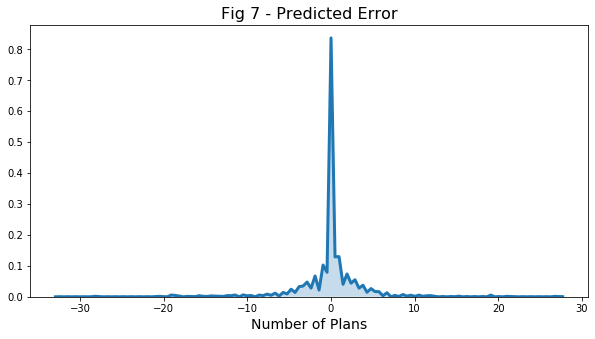

In [19]:
# distribution of errors
plt.figure(figsize=(10,5))

_ = sns.distplot(errors_rf, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})
_ = plt.title("Fig 7 - Predicted Error", size=16)
_ = plt.xlabel("Number of Plans", size=14)

plt.savefig("In Depth-RandomForestError.png")


Looking further into how you get to this fit, we observed that there the main results are driven by a couple of features. The number of issuers present in the market is the main feature used to predict the number of plan options. The second two highly relevant features are the indicators for the states of Florida and Wisconsin. These two states seem to behave like outliers when compared with the rest of the states. Population size in the area, county median income, and enrollment in this market in the previous year follow in relevance (see Top 10 Features figure).

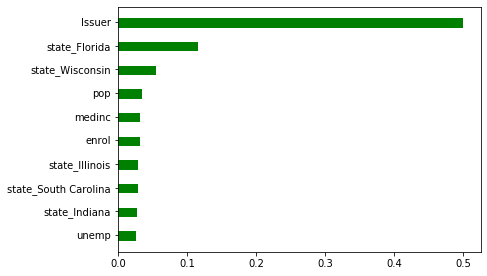

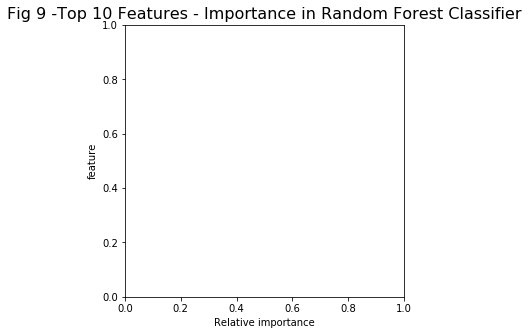

In [20]:
# Identify the top features used in the model for prediction
y_fi = pd.Series(rf_mod.feature_importances_,index=XP.columns)
y_fi_top10 = y_fi.sort_values()[-10:]

#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y_fi_top10)) # the x locations for the groups
ax.barh(ind, y_fi_top10, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(y_fi_top10.index, minor=False)
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)
plt.title('Fig 9 -Top 10 Features - Importance in Random Forest Classifier', size=16)
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.savefig("In Depth-RandomForestFeatures.png")


## Conclusion

The number of health insurance plans offered in any particular geographic area in the US where the exchanges are federally moderated shows high levels of variability. The number of issuers in each market is very low, with many areas limited to just one company. This points to a low level of competition, though due to high variability in the number of plans, some areas still present the consumer with a significant number of options.

The distribution of the number of plans differs by state. Since the ACA implementation and regulation has been a highly political topic, we test whether the state’s color (Governor’s political party affiliation) has an effect on this distribution. We observe a significant difference in the number of plans offered in Republican states than in Democratic states, though this difference is small in size (1.7). 

The number of plans can be predicted using market characteristics with different approaches. The best predictive model identified is the Random Forest, with slight improvement over the linear regression fit. Besides the high correlation between plans and number of issuers, other variables still have additional predictive power. In particular, two states seem to deviate from the rest, Florida and Winsconsin.

Further analysis into the state facilitated markets is necessary to better inform the prediction of plans offered across the US. From this preliminary analysis it is clear that the health insurance market is highly concentrated and the options a consumer faces highly depend on the ability of the market to attract insurers.
